In [1026]:
# Import Libraries
from PIL import Image
import cv2
from plantcv import plantcv as pcv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# from colorspacious import cspace_converter
from collections import OrderedDict

cmaps = OrderedDict()

In [1027]:
def display(img,cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap=cmap)

In [1028]:
class options:
    def __init__(self):
        self.image = "/Users/garethtate/plantcv/TestImagesRPi/Still-1-RGB-2021-07-05_14-12-38.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "ROINDVI_test_results.json"
        self.outdir = "/Users/garethtate/plantcv" # Store the output to the current directory

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

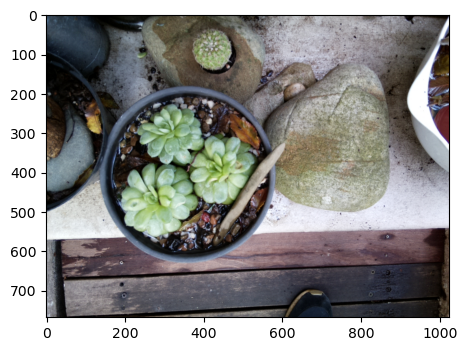

In [1029]:
# Read image 

# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv' 
img, path, filename = pcv.readimage(filename=args.image)

In [1030]:
img.shape

(768, 1024, 3)

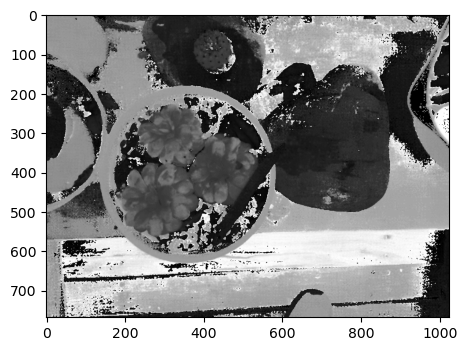

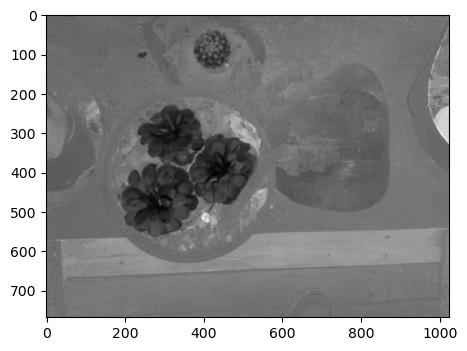

In [1031]:
h_channel = pcv.rgb2gray_hsv(rgb_img=img, channel='h')
a_channel = pcv.rgb2gray_lab(rgb_img=img, channel='a')

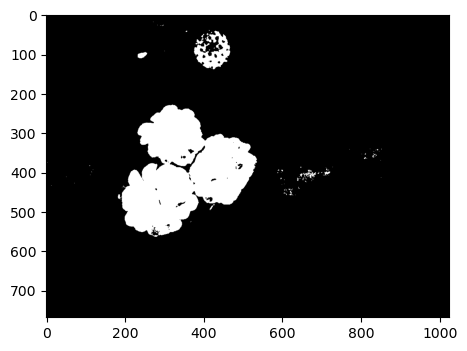

In [1032]:
threshold_light_a = pcv.threshold.otsu(gray_img=a_channel, max_value=255, object_type='dark')
# threshold_light_h = pcv.threshold.otsu(gray_img=h_channel, max_value=255, object_type='dark')

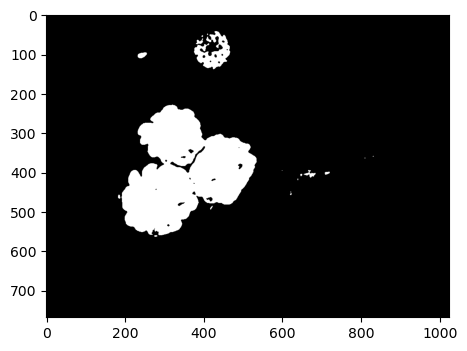

In [1033]:
binary_img = pcv.median_blur(gray_img=threshold_light_a, ksize=5)

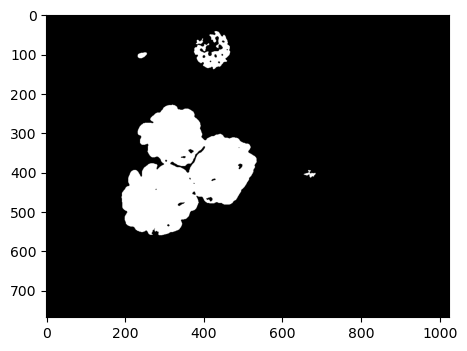

In [1034]:
# Fill in small objects (speckles)

# Inputs:
#    bin_img  = binary image. img will be returned after filling
#    size     = minimum object area size in pixels (integer)
fill_image = pcv.fill(bin_img=binary_img, size=100)
#                                                ^
#                                                |
#                                 adjust this value

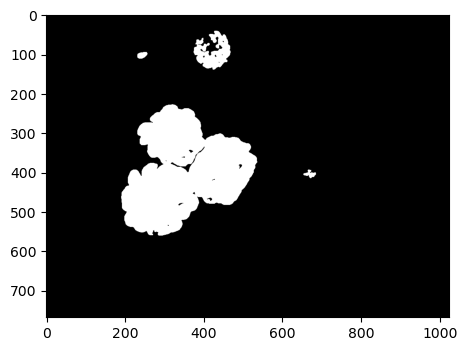

In [1035]:
# Dilate so that you don't lose leaves (just in case)

# Inputs:
#    gray_img = input image
#    ksize    = integer, kernel size
#    i        = iterations, i.e. number of consecutive filtering passes
dilated = pcv.dilate(gray_img=fill_image, ksize=3, i=1)

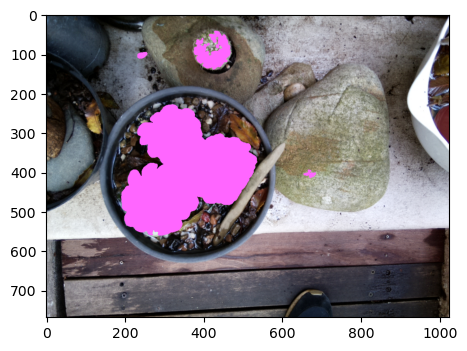

In [1036]:
# Find objects (contours: black-white boundaries)

# Inputs:
#    img  = image that the objects will be overlayed
#    mask = what is used for object detection
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=dilated)

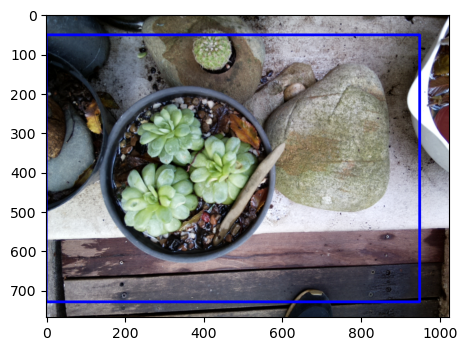

In [1037]:
# Define region of interest (ROI)

# Inputs:
#    img   = An RGB or grayscale image to plot the ROI on.
#    x     = The x-coordinate of the upper left corner of the rectangle.
#    y     = The y-coordinate of the upper left corner of the rectangle.
#    h     = The width of the rectangle.
#    w     = The height of the rectangle.
#   roi_contour, roi_hierarchy = pcv.roi.rectangle(5, 90, 200, 390, img1) 
#                                                  |______________|
#                                            adjust these four values
roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img, x=0, y=50, h=680, w=950)

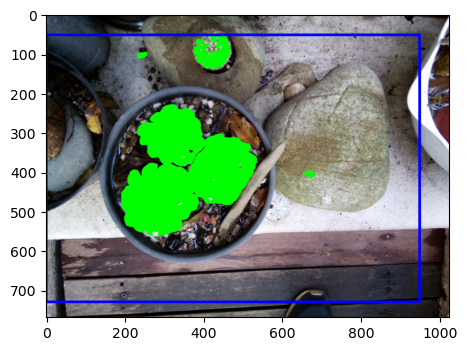

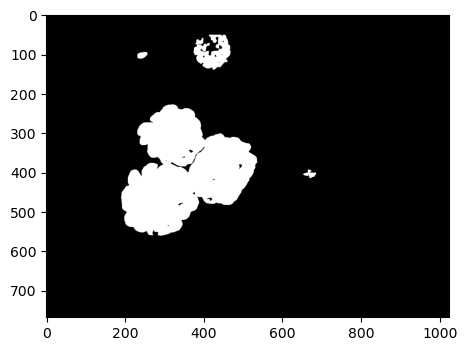

In [1038]:
# Keep objects that overlap with the ROI

# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)

roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi_contour, 
                                                                      roi_hierarchy=roi_hierarchy,
                                                                      object_contour=id_objects, 
                                                                      obj_hierarchy=obj_hierarchy, 
                                                                      roi_type='cutto')

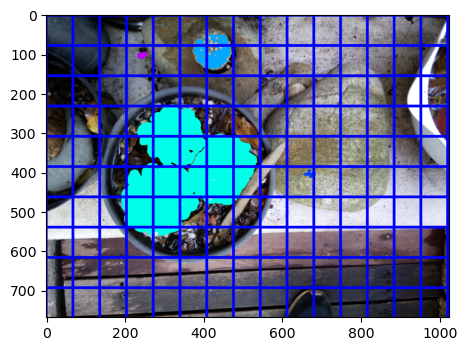

In [1039]:
# This function take a image with multiple contours and
# clusters them based on user input of rows and columns

# Inputs:
#    img               = An RGB or grayscale image
#    roi_objects       = object contours in an image that are needed to be clustered.
#    roi_obj_hierarchy = object hierarchy
#    nrow              = number of rows to cluster (this should be the approximate  number of 
#                        desired rows in the entire image even if there isn't a literal row of plants)
#    ncol              = number of columns to cluster (this should be the approximate number of 
#                        desired columns in the entire image even if there isn't a literal row of plants)
#    show_grid         = if True then the grid is drawn on the image, default show_grid=False
clusters_i, contours, hierarchies = pcv.cluster_contours(img=img, roi_objects=roi_objects, 
                                                         roi_obj_hierarchy=roi_obj_hierarchy, 
                                                         nrow=10, ncol=15, 
                                                         show_grid=True)


In [1040]:
# # Inputs:
# # mask             = Mask/binary image to segment into clusters.
# # algorithm        = Algorithm to use for segregating different clusters.
# #                    Currently supporting OPTICS and DBSCAN. (Default="DBSCAN")
# # min_cluster_size = The minimum size a section of a mask must be (in pixels)
# #                    before it can be considered its own cluster. (Default=5)
# # max_distance     = The total distance between two pixels for them to be considered a part
# #                    of the same cluster.  For the DBSCAN algorithm, value must be between
# #                    0 and 1.  For OPTICS, the value is in pixels and depends on the size
# #                    of your picture.  (Default=0)
# clust_img, clust_masks = pcv.spatial_clustering(mask=kept_mask, algorithm="DBSCAN", min_cluster_size=5, max_distance=None)



In [1041]:
# # Set the sequence of colors from the color_scale created by the 
# # color_palette function to "sequential" or "random" order. 
# # Default = "sequential". 
# pcv.params.color_sequence = 'random'
# cluster_img = pcv.visualize.clustered_contours(img=img, grouped_contour_indices=clusters_i, 
#                                                 roi_objects=contours,
#                                                 roi_obj_hierarchy=hierarchies)

In [1042]:
crop_img_arrRGB = []
img_rect = img.copy()
height, width, channels = img.shape

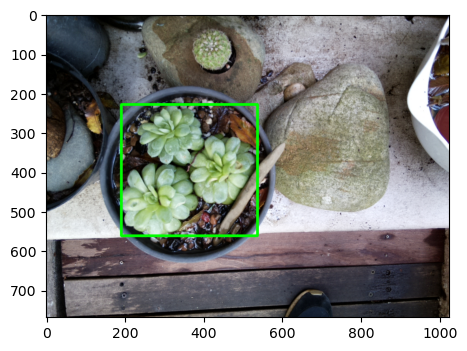

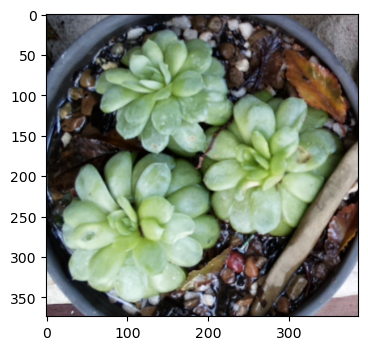

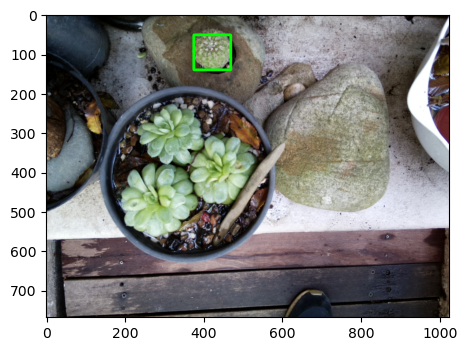

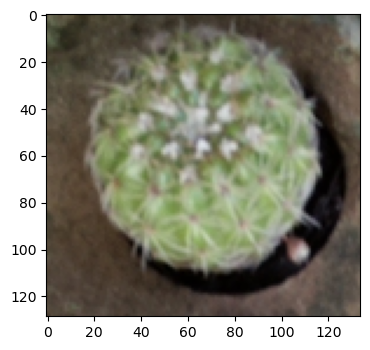

In [1043]:
for i in range(len(contours)):
    if hierarchies[0][i][3] == -1:
        x,y,w,h = cv2.boundingRect(contours[i])
        cv2.rectangle(img_rect,(x,y),(x+w,y+h),(0,255,0),2)
        
        if h >= 0.08*height and w >= 0.08*width:
            crop_img = pcv.auto_crop(img=img, obj=contours[i], padding_x=20, padding_y=20, color='image')
            crop_img_arrRGB.append(crop_img)

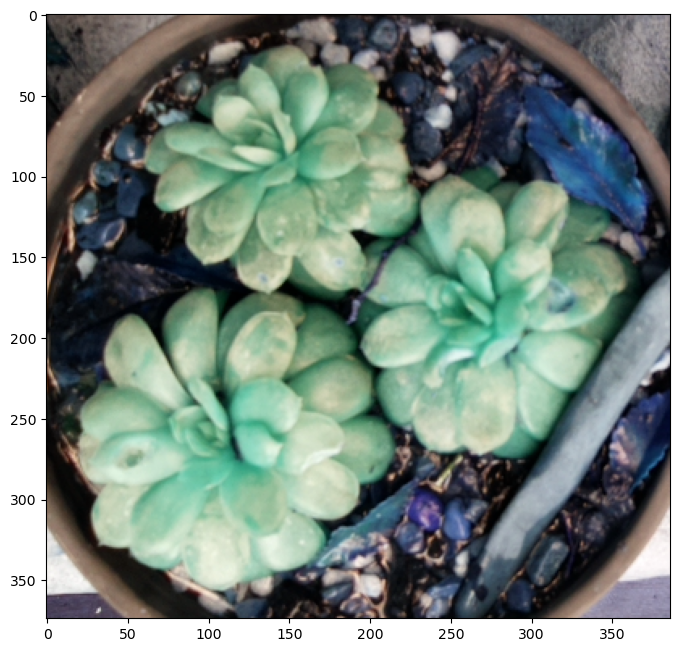

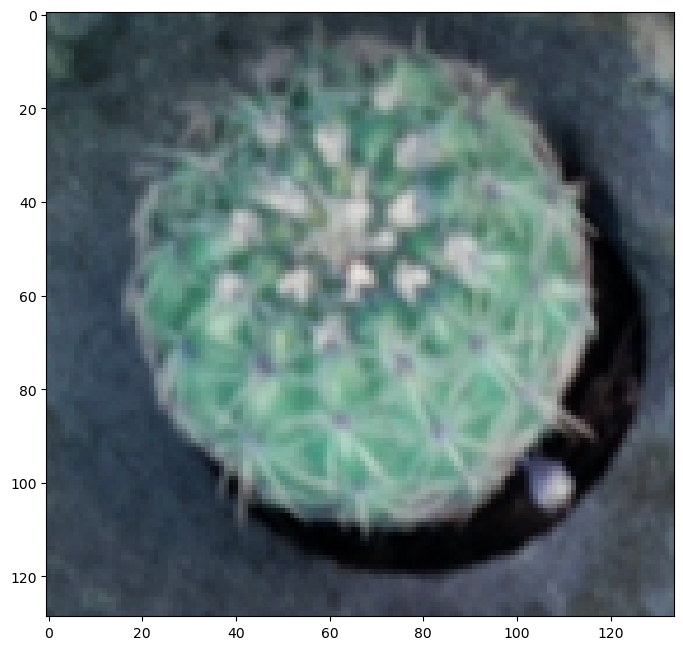

In [1044]:
for i in range(len(crop_img_arrRGB)):
    display(crop_img_arrRGB[i])


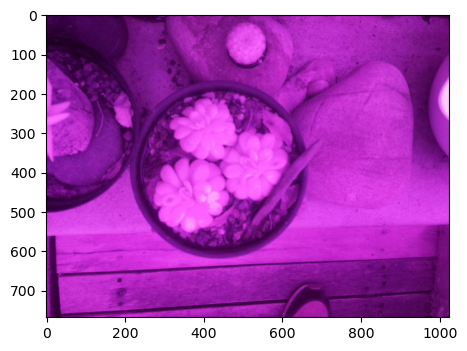

In [1045]:
# Read image 

# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv' 
img, path, filename = pcv.readimage(filename="/Users/garethtate/plantcv/TestImagesRPi/Still-1-RGBN-2021-07-05_14-12-35.jpg")



In [1046]:
# All the 6 methods for comparison in a list
# Note how we are using strings, later on we'll use the eval() function to convert to function
methods = ['cv2.TM_CCOEFF', 'cv2.TM_SQDIFF_NORMED', 'cv2.TM_CCORR','cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_CCOEFF_NORMED']

In [1047]:
crop_img_arrNIR = []

*****************************************************************


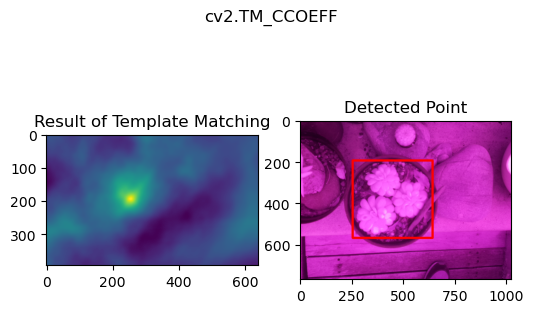

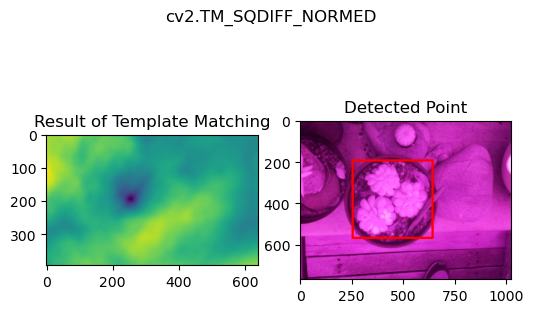

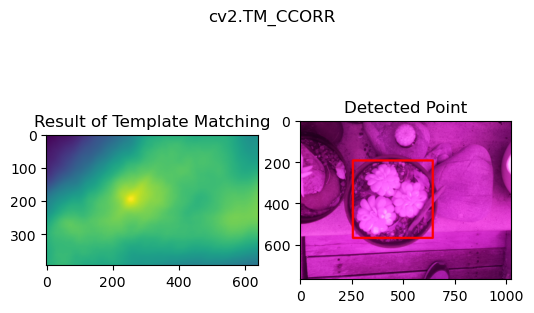

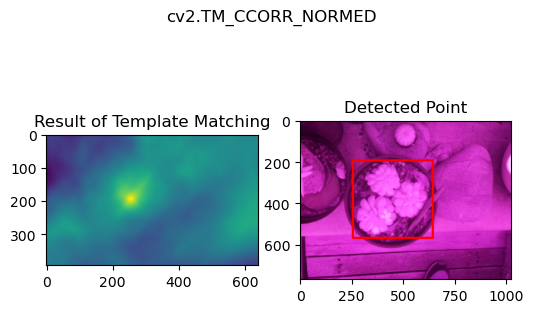

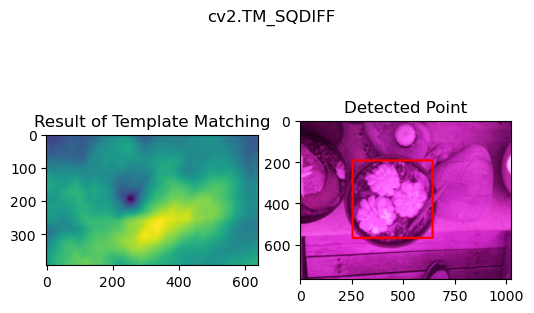

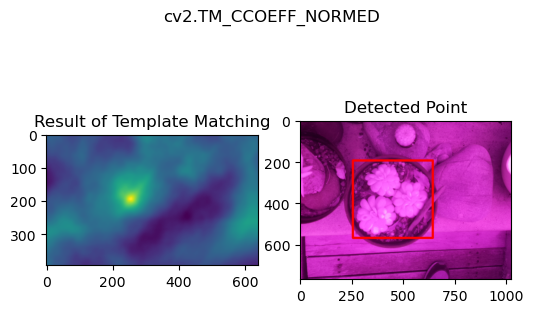

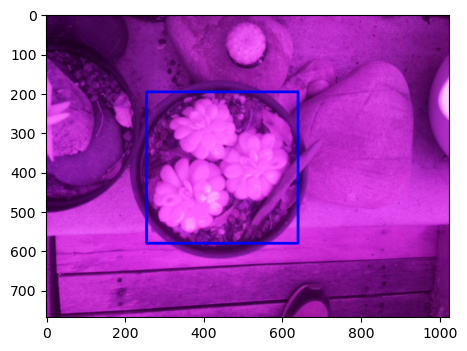

*****************************************************************


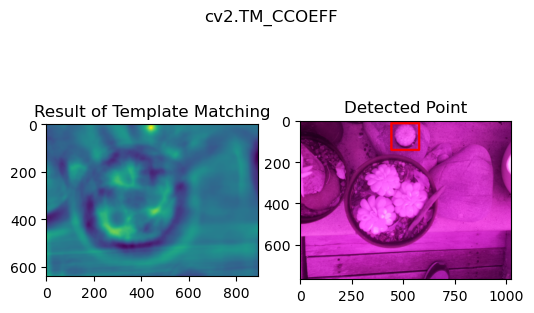

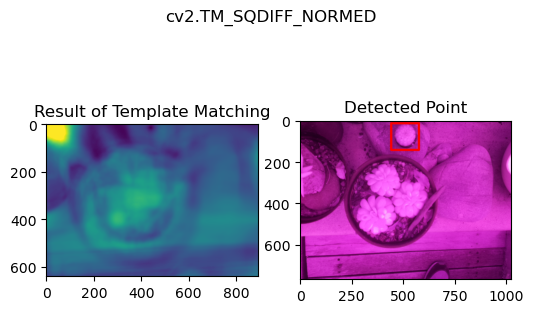

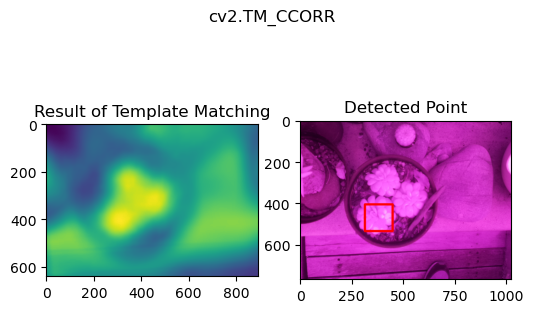

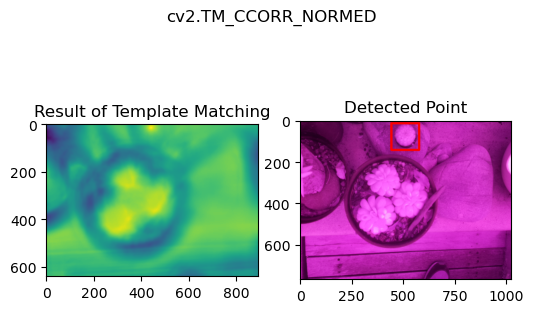

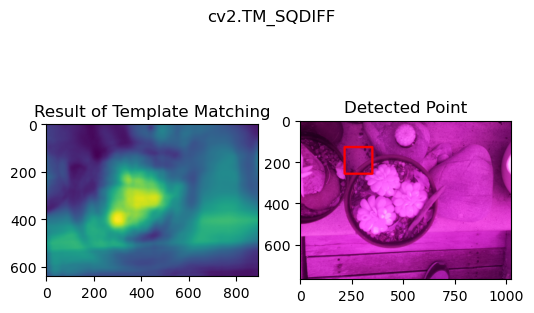

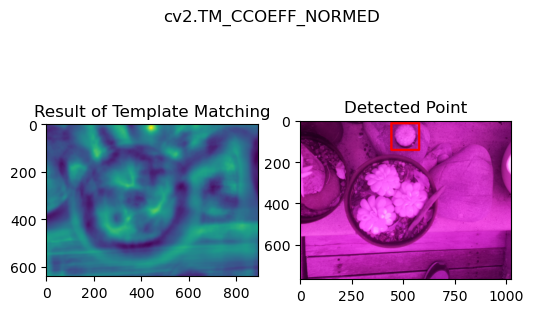

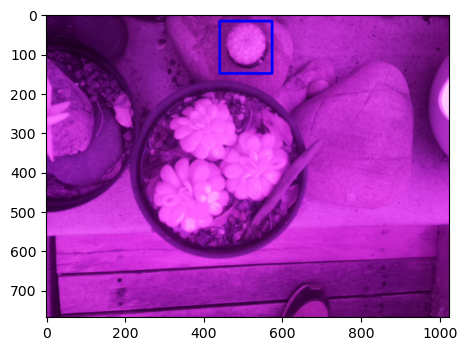

In [1048]:
for k in range(len(crop_img_arrRGB)):
    print('*****************************************************************')
    crop_h, crop_w, crop_chan =  crop_img_arrRGB[k].shape

    for m in methods:
    
        # Create a copy of the image
        full_copy = img.copy()
    
        # Get the actual function instead of the string
        method = eval(m)

        # Apply template Matching with the method
        res = cv2.matchTemplate(full_copy,crop_img_arrRGB[k],method)
    
        # Grab the Max and Min values, plus their locations
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
        # Set up drawing of Rectangle
    
        # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
        # Notice the coloring on the last 2 left hand side images.
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc    
        else:
            top_left = max_loc
        
        # Assign the Bottom Right of the rectangle (assuming images have same w & h)
        bottom_right = (top_left[0] + crop_w, top_left[1] + crop_h)
        
        
        # Draw the Red Rectangle
        cv2.rectangle(full_copy,top_left, bottom_right, 255, 10)

        # Plot the Images
        plt.subplot(121)
        plt.imshow(res)
        plt.title('Result of Template Matching')
    
        plt.subplot(122)
        plt.imshow(full_copy)
        plt.title('Detected Point')
        plt.suptitle(m)
    
    
        plt.show()
        print('\n')
        print('\n')
        
    # Crop image
    crop_imgNIR = pcv.crop(img=img, x=top_left[0], y=top_left[1], h=crop_w, w=crop_w)
    crop_img_arrNIR.append(crop_imgNIR)
    

In [1049]:
#Overlap and NDVI calc.
# pcv.plot_image(img[:,:,2])

In [1050]:
# plt.imshow(crop_img_arrRGB[0])

In [1051]:
crop_img_arrRGB[1].shape[0]
cmap = 'gist_earth'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 70.  76.  89. ... 147. 138. 139.]
 [ 66.  71.  80. ... 153. 147. 140.]
 [ 68.  73.  84. ... 157. 155. 140.]
 ...
 [ 71.  69.  69. ... 135. 142. 144.]
 [ 76.  74.  74. ... 126. 134. 137.]
 [ 71.  75.  67. ... 138. 136. 143.]]




[[135.99962032 137.97555387 134.98834646 ... 199.02368677 200.05997628
  206.03704888]
 [136.07720947 135.93954957 133.85230702 ... 201.20660162 205.39019549
  209.01760006]
 [138.03706402 135.79693896 130.9076013  ... 205.60970581 211.31425309
  207.10126919]
 ...
 [222.89822268 223.88439536 222.01826477 ... 226.84681904 225.96686113
  226.41545236]
 [224.92444789 224.96387738 222.9278664  ... 229.0896219  227.15844864
  222.24425626]
 [225.00037956 225.00018978 223.98795903 ... 224.06153333 221.0735743
  219.03593314]]
[[ 73.  84.  77. ... 101.  84.  69.]
 [ 73.  86.  80. ... 103.  96.  78.]
 [ 74.  80.  82. ... 111. 108.  95.]
 ...
 [ 67.  60.  57. ...  96.  95.  91.]
 [ 56.  59.  58. ...  98.  94.  89.]
 [ 49.  52.  64. ...  96.  90.  85.]]




[[119.043

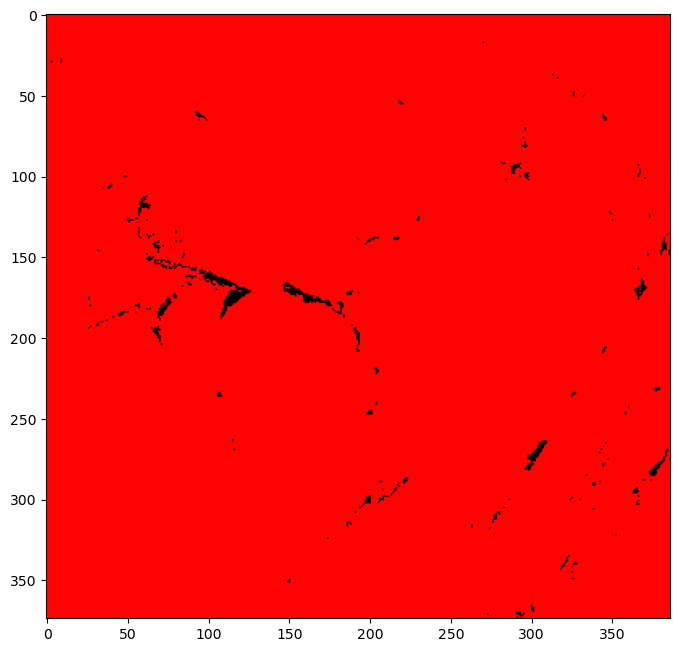

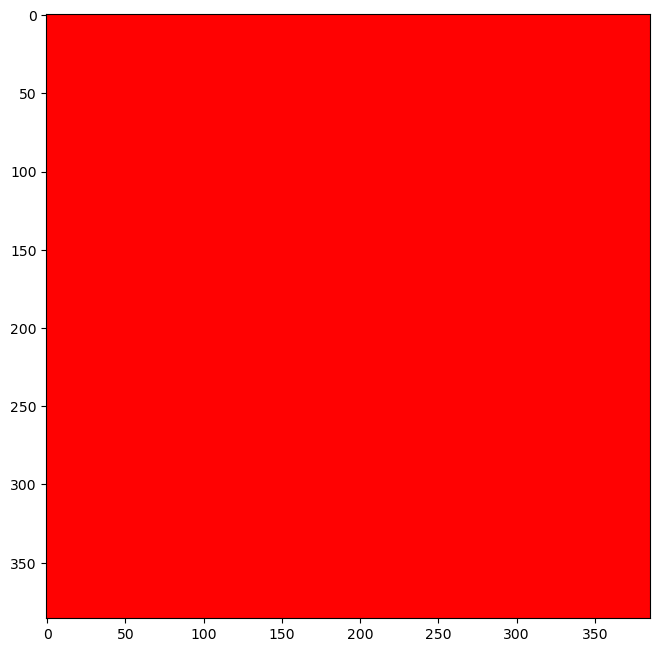

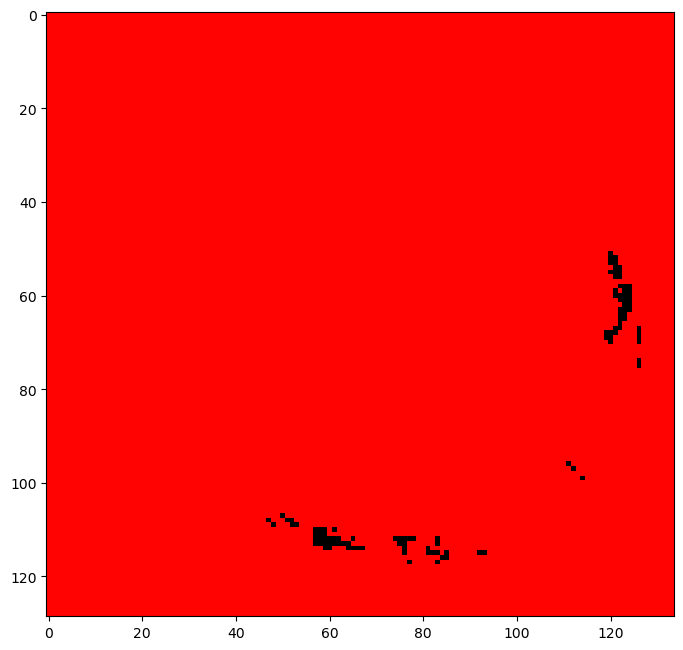

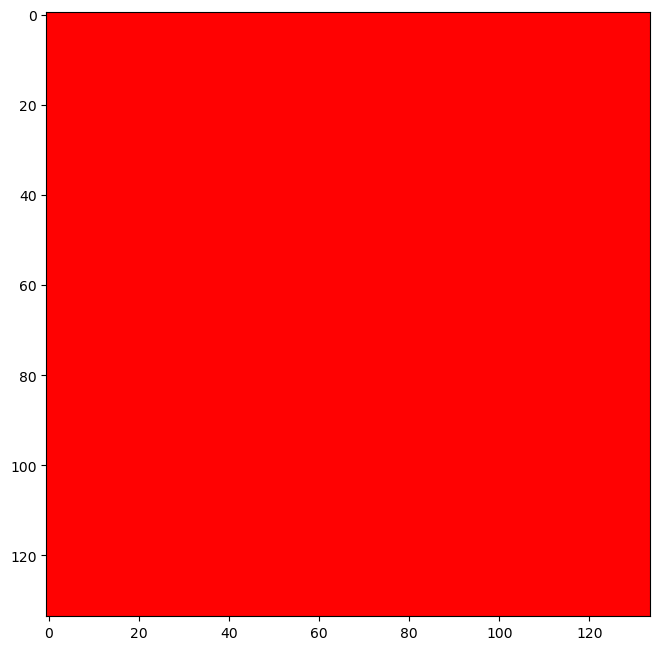

In [1057]:
#do a check to make sure that the rgb and nir arr are the same length

for i in range(len(crop_img_arrRGB)):
    
    
#     display(crop_img_arrRGB[i][:,:,0])
#     display(crop_img_arrNIR[i][:,:,0])
    
    VISimgR = crop_img_arrRGB[i].astype('float')
    
    VISimgR[:,:,1] = 0.01
    VISimgR[:,:,2] = 0.01
    display(VISimgR) 
    
    NIRimgNR = crop_img_arrNIR[i].astype('float')
    
    
    NIRimgNR[:,:,1] = 0.01
    NIRimgNR[:,:,2] = 0.01
    display(NIRimgNR)
    
    

    if NIRimgNR.shape[0] < VISimgR.shape[0]:
        #np.resize(VISimgR[:], new_shape)
        
        #VISimgR = cv2.resize(img, dsize=(54, 140), interpolation=cv2.INTER_CUBIC)
        VISimgR = cv2.resize(VISimgR, dsize=(VISimgR.shape[1], NIRimgNR.shape[0]), interpolation=cv2.INTER_CUBIC)        
        # Resize image using resize function, with interpolation, and default interpolation method
        #VISimgR = pcv.transform.resize(img=VISimgR, size=(NIRimgNR.shape[0], VISimgR.shape[1]), interpolation="auto")
        
    if NIRimgNR.shape[0] > VISimgR.shape[0]:
        
        NIRimgNR = cv2.resize(NIRimgNR, dsize=(NIRimgNR.shape[1], VISimgR.shape[0]), interpolation=cv2.INTER_CUBIC) 
        # Resize image using resize function, with interpolation, and default interpolation method
        #NIRimgNR = pcv.transform.resize(img=NIRimgNR, size=(VISimgR.shape[0], NIRimgNR.shape[1]), interpolation="auto")
        
    if NIRimgNR.shape[1] < VISimgR.shape[1]:
                
        VISimgR = cv2.resize(VISimgR, dsize=(NIRimgNR.shape[1],VISimgR.shape[0]), interpolation=cv2.INTER_CUBIC) 
        # Resize image using resize function, with interpolation, and default interpolation method
        #VISimgR = pcv.transform.resize(img=VISimgR, size=(VISimgR.shape[0], NIRimgNR.shape[1]), interpolation="auto")
        
    if NIRimgNR.shape[1] > VISimgR.shape[1]:
        
        NIRimgNR = cv2.resize(NIRimgNR, dsize=(VISimgR.shape[1], NIRimgNR.shape[0]), interpolation=cv2.INTER_CUBIC)     
        # Resize image using resize function, with interpolation, and default interpolation method
        #NIRimgNR = pcv.transform.resize(img=NIRimgNR, size=(NIRimgNR.shape[0], VISimgR.shape[1]), interpolation="auto")
    
    
    
    
    
    
    NIRactual =  NIRimgNR[:,:,0] #.astype('float') #- VISimgR[:,:,0] 
#     #NIRactual=np.clip(NIRactual,a_min=0.01, a_max=255)
    
    VISactual = VISimgR[:,:,0] #.astype('float')
    
#     compare = np.hstack((NIRactual, VISactual))
    
    NDVI = (NIRactual-(VISactual))/(NIRactual+(VISactual))
    NDVI[np.isnan(NDVI)] = 0
    #if neg
#     NDVI = (NDVI+np.abs(np.min(NDVI)))
#     NDVI = (NDVI/np.max(NDVI))*255
#     NDVI = NDVI.astype(int)
#     print(np.max(NDVI), np.min(NDVI))
#     print('\n')
#     print(NDVI)
    print(VISimgR[:,:,0])


    print('\n')
    print('\n')
    
    print(NIRimgNR[:,:,0])  

#     def plot_examples(colormaps):
#         """
#         Helper function to plot data with associated colormap.
#         """
#         display(NDVI, cmap = 'gist_earth')
        
#         np.random.seed(19680801)
#         data = np.random.randn(30, 30)
        
#         n = len(colormaps)
#         fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
#                             constrained_layout=True, squeeze=False)
#         for [ax, cmap] in zip(axs.flat, colormaps):
#             psm = ax.pcolormesh(NDVI, cmap=cmap, rasterized=True, vmin=-1, vmax=1)
#             fig.colorbar(psm, ax=ax)
#         plt.show()

    #cmap = ListedColormap(["darkorange", "gold", "lawngreen", "lightseagreen"])
#     plot_examples([cmap])

   
    
